Master split already exists at: Artifacts/master_split_indices.joblib
Dataset loaded: 3303 rows


INFO:helpers_text_preprocessing:Successfully loaded spaCy model: en_core_web_sm
INFO:helpers_text_preprocessing:Starting enhanced text preprocessing pipeline...
INFO:helpers_text_preprocessing:  Step 1/4: Unicode normalization and mojibake removal
INFO:helpers_text_preprocessing:  Step 2/4: Preserving legal multiword terms
INFO:helpers_text_preprocessing:  Step 3/4: spaCy processing (batch_size=100, n_process=4)
INFO:helpers_text_preprocessing:  Step 4/4: Final cleanup and validation
INFO:helpers_text_preprocessing:Preprocessing complete. Average tokens per document: 92.1


Saving all results to: /Users/fpmuga/Documents/00-MathClasses/2025-2026/1_FirstSemester_2025-2026/MATH_130.1-UV1_2025-1/MUGA_LAB/03_Notebooks/MUGA_LAB/Artifacts
Using fixed master split indices for all tasks.

Determining max_features per task using coverage curve...


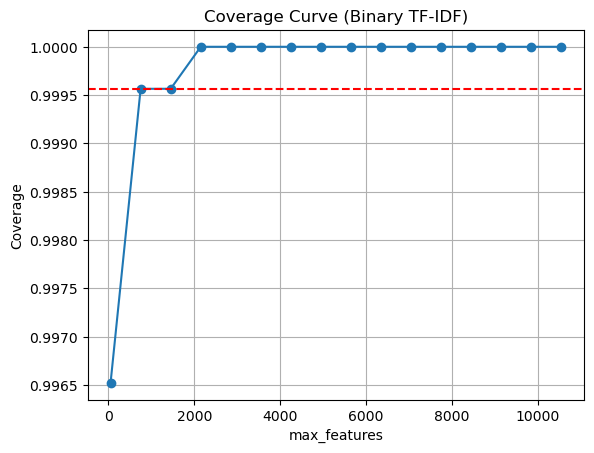

Selected max_features=750 for Binary TF-IDF (99.957% coverage)


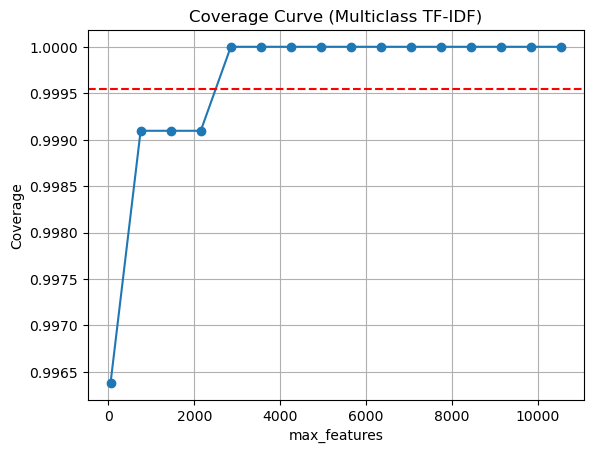

Selected max_features=2850 for Multiclass TF-IDF (100.000% coverage)


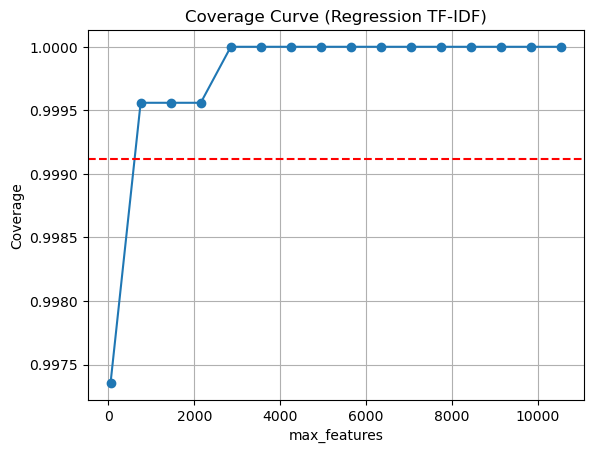

Selected max_features=750 for Regression TF-IDF (99.956% coverage)

Processing variant: BAG_OF_WORDS
✅ Saved vectorizer and splits to: /Users/fpmuga/Documents/00-MathClasses/2025-2026/1_FirstSemester_2025-2026/MATH_130.1-UV1_2025-1/MUGA_LAB/03_Notebooks/MUGA_LAB/Artifacts/binary/binary_bag_of_words_750f.joblib
✅ Saved vectorizer and splits to: /Users/fpmuga/Documents/00-MathClasses/2025-2026/1_FirstSemester_2025-2026/MATH_130.1-UV1_2025-1/MUGA_LAB/03_Notebooks/MUGA_LAB/Artifacts/multiclass/multiclass_bag_of_words_2850f.joblib
✅ Saved vectorizer and splits to: /Users/fpmuga/Documents/00-MathClasses/2025-2026/1_FirstSemester_2025-2026/MATH_130.1-UV1_2025-1/MUGA_LAB/03_Notebooks/MUGA_LAB/Artifacts/regression/regression_bag_of_words_750f.joblib

Processing variant: TFIDF_UNIGRAM
✅ Saved vectorizer and splits to: /Users/fpmuga/Documents/00-MathClasses/2025-2026/1_FirstSemester_2025-2026/MATH_130.1-UV1_2025-1/MUGA_LAB/03_Notebooks/MUGA_LAB/Artifacts/binary/binary_tfidf_unigram_750f.joblib
✅ 

In [1]:
# =============================================
# Traditional Vectorization of Justice Dataset
# (Synchronized with Embedding Vectorization)
# =============================================

# ---------------------------
# 1. Setup and Imports
# ---------------------------
from generate_master_split import ensure_master_split
ensure_master_split()

import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from helpers_text_preprocessing import (
    load_spacy_model,
    enhanced_spacy_preprocessing
)
from helpers_traditional_vectorization import (
    vectorize_text, save_results, select_max_features
)

MASTER_SPLIT_PATH = "Artifacts/master_split_indices.joblib"

# ---------------------------
# 2. Load Dataset
# ---------------------------
justice_df = pd.read_csv("../Justice_Dataset/justice.csv", index_col=0)
print(f"Dataset loaded: {justice_df.shape[0]} rows")

# ---------------------------
# 3. Text Preprocessing
# ---------------------------
nlp = load_spacy_model("en_core_web_sm")
justice_df["facts_clean"] = enhanced_spacy_preprocessing(
    texts=justice_df["facts"],
    nlp=nlp,
    keep_negations=True,
    preserve_legal_terms=True,
    batch_size=100,
    n_process=4
)

# ---------------------------
# 4. Task Variants Setup
# ---------------------------
try:
    BASE_DIR = os.path.abspath(os.path.dirname(__file__))
except NameError:
    BASE_DIR = os.getcwd()

ARTIFACTS_DIR = os.path.join(BASE_DIR, "Artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print(f"Saving all results to: {ARTIFACTS_DIR}")

# --- Binary classification ---
binary_df = justice_df[["facts_clean", "first_party_winner"]].dropna()

# --- Multiclass classification ---
multiclass_df = justice_df[["facts_clean", "issue_area"]].dropna()
merge_map = {"Private Action": "Miscellaneous", "Interstate Relations": "Miscellaneous"}
multiclass_df["issue_area"] = multiclass_df["issue_area"].replace(merge_map)

# --- Regression ---
justice_df["term_year"] = pd.to_numeric(justice_df["term"], errors="coerce")
regression_df = justice_df[["facts_clean", "term_year"]].dropna()

# ---------------------------
# 5. Load Master Split Indices (3 Tasks)
# ---------------------------
try:
    all_splits = joblib.load(MASTER_SPLIT_PATH)
    print("Using fixed master split indices for all tasks.")
except FileNotFoundError:
    raise RuntimeError("Master split not found — please run generate_master_split.py first.")

# ---------------------------
# 6. Extract Synchronized Splits
# ---------------------------

# --- Binary ---
split_bin = all_splits["binary"]
X_train_bin = binary_df.loc[split_bin["train_idx"], "facts_clean"]
X_val_bin   = binary_df.loc[split_bin["val_idx"], "facts_clean"]
X_test_bin  = binary_df.loc[split_bin["test_idx"], "facts_clean"]
y_train_bin = binary_df.loc[split_bin["train_idx"], "first_party_winner"]
y_val_bin   = binary_df.loc[split_bin["val_idx"], "first_party_winner"]
y_test_bin  = binary_df.loc[split_bin["test_idx"], "first_party_winner"]

# --- Multiclass ---
split_multi = all_splits["multiclass"]
X_train_multi = multiclass_df.loc[split_multi["train_idx"], "facts_clean"]
X_val_multi   = multiclass_df.loc[split_multi["val_idx"], "facts_clean"]
X_test_multi  = multiclass_df.loc[split_multi["test_idx"], "facts_clean"]
y_train_multi = multiclass_df.loc[split_multi["train_idx"], "issue_area"]
y_val_multi   = multiclass_df.loc[split_multi["val_idx"], "issue_area"]
y_test_multi  = multiclass_df.loc[split_multi["test_idx"], "issue_area"]

# --- Regression ---
split_reg = all_splits["regression"]
X_train_reg = regression_df.loc[split_reg["train_idx"], "facts_clean"]
X_val_reg   = regression_df.loc[split_reg["val_idx"], "facts_clean"]
X_test_reg  = regression_df.loc[split_reg["test_idx"], "facts_clean"]
y_train_reg = regression_df.loc[split_reg["train_idx"], "term_year"]
y_val_reg   = regression_df.loc[split_reg["val_idx"], "term_year"]
y_test_reg  = regression_df.loc[split_reg["test_idx"], "term_year"]

# ---------------------------
# 7. Feature Selection
# ---------------------------
print("\nDetermining max_features per task using coverage curve...")

binary_max_feats = select_max_features(X_train_bin, "Binary TF-IDF", "tfidf", 0.99956)
multiclass_max_feats = select_max_features(X_train_multi, "Multiclass TF-IDF", "tfidf", 0.99955)
regression_max_feats = select_max_features(X_train_reg, "Regression TF-IDF", "tfidf", 0.99912)

# ---------------------------
# 8. Vectorization Variants
# ---------------------------
variants = {
    "bag_of_words": {"method": "count"},
    "tfidf_unigram": {"method": "tfidf"},
    "tfidf_ngram": {"method": "tfidf", "ngram_range": (1, 2)},
}

# ---------------------------
# 9. Apply to Each Task
# ---------------------------
for variant_name, params in variants.items():
    print(f"\nProcessing variant: {variant_name.upper()}")

    ngram_mult = 2 if params.get("ngram_range") == (1, 2) else 1
    max_bin, max_multi, max_reg = (
        binary_max_feats * ngram_mult,
        multiclass_max_feats * ngram_mult,
        regression_max_feats * ngram_mult,
    )

    # Create subfolders
    os.makedirs(os.path.join(ARTIFACTS_DIR, "binary"), exist_ok=True)
    os.makedirs(os.path.join(ARTIFACTS_DIR, "multiclass"), exist_ok=True)
    os.makedirs(os.path.join(ARTIFACTS_DIR, "regression"), exist_ok=True)

    # --- Binary ---
    vec, X_train, X_val, X_test = vectorize_text(
        X_train_bin, X_val_bin, X_test_bin,
        method=params["method"], max_features=max_bin
    )
    save_results(
        vec, X_train, y_train_bin, X_val, y_val_bin, X_test, y_test_bin,
        os.path.join(ARTIFACTS_DIR, "binary", f"binary_{variant_name}_{max_bin}f.joblib")
    )

    # --- Multiclass ---
    vec, X_train, X_val, X_test = vectorize_text(
        X_train_multi, X_val_multi, X_test_multi,
        method=params["method"], max_features=max_multi
    )
    save_results(
        vec, X_train, y_train_multi, X_val, y_val_multi, X_test, y_test_multi,
        os.path.join(ARTIFACTS_DIR, "multiclass", f"multiclass_{variant_name}_{max_multi}f.joblib")
    )

    # --- Regression ---
    vec, X_train, X_val, X_test = vectorize_text(
        X_train_reg, X_val_reg, X_test_reg,
        method=params["method"], max_features=max_reg
    )
    save_results(
        vec, X_train, y_train_reg, X_val, y_val_reg, X_test,  y_test_reg,
        os.path.join(ARTIFACTS_DIR, "regression", f"regression_{variant_name}_{max_reg}f.joblib")
    )

print("\nTraditional vectorization complete. All results saved under Artifacts/.")